In [112]:
%matplotlib inline

In [113]:
import torch
import numpy as np
import pypose as pp

from matplotlib.patches import Circle
from matplotlib import pyplot as plt

# Dead Reckoning

In [114]:
def v2t(vec):
    x, y, theta = vec
    return np.array([
        [np.cos(theta), -np.sin(theta), x],
        [np.sin(theta),  np.cos(theta), y],
        [            0,              0, 1]
    ])
    
    
def t2v(mat):
    x = mat[0, 2]
    y = mat[1, 2]
    R = mat[:2, :2] 
    theta = np.arctan2(R[1, 0], R[0, 0])
    return np.array([x, y, theta])

def save_poses_kitti(poses, filename="data\data_kitti.txt"):
    # data = []
    for i in range(poses.shape[1]):
        vec = poses[:, i]
        x = vec[0]
        y = vec[1]
        theta = vec[2]
        with open(filename, "a+") as f:
            f.write(f"""{np.cos(theta)} {-np.sin(theta)} {0} {x} {np.sin(theta)} {np.cos(theta)} {0} {y} {0} {0} {1} {0}\n""")

In [115]:
# visualize
def plot(points):
    fig, ax = plt.subplots()

    circle = Circle((-1, 0), 1, color='blue', fill=False)
    ax.add_patch(circle)
    
    x = points[0]
    y = points[1]
    plt.plot(x, y, '-o', label='Trajectory')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_aspect('equal')

    plt.show()

In [116]:
relative_poses = np.loadtxt("D:\Courses\CS284-SLAM\hw1\data\hw1_data.txt")
trans_matrixes  = [v2t(relative_pose.reshape(3)) for relative_pose in relative_poses.T]
poses = [np.zeros((3,1))]
position = np.identity(3)

for i in range(12):
    Zi = trans_matrixes[i]
    position =  position @ Zi
    # trans_matrixes.append(position)
    poses.append((t2v(position).T).reshape(3,1))
    
poses = np.stack(poses).reshape(13, 3).T
# save_poses_kitti(poses)

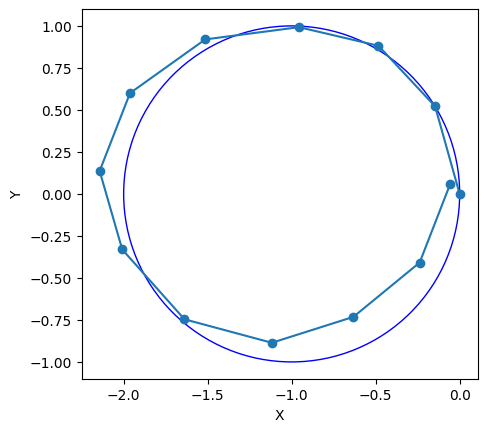

In [117]:
plot(poses)

# Graph optimization

In [118]:
poses = poses[:, :-1]

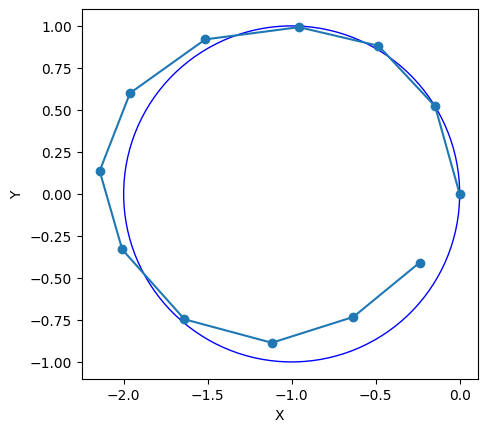

In [119]:
plot(poses)

In [120]:
def error_function(xi, xj, Zij):
    xi_mat = v2t(xi)
    xj_mat = v2t(xj)
    error_mat = np.linalg.inv(Zij) @ (np.linalg.inv(xi_mat) @ (xj_mat))
    return t2v(error_mat)


def compute_Jacob(xi, xj, trans_mat_ij):
    """
    e(xi, xj) = log(xi_mat.inverse() @ xj_mat @ trans_mat_ij.inverse()) 关于节点位姿的雅可比矩阵
    
    Args:
        xi (np.ndarray): 节点i的位姿(x, y, theta)
        xj (np.ndarray): 节点j的位姿(x, y, theta)
        trans_mat_ij (np.ndarray): 从节点i到节点j的观测相对位姿(3x3矩阵)
        
    Returns:
        A (np.ndarray): de(xi, xj)/dxi
        B (np.ndarray): de(xi, xj)/dxj
    """
    xi_mat = v2t(xi)  # 3x3 matrix
    xj_mat = v2t(xj)
    
    Ri = xi_mat[:2, :2]
    ti = xi_mat[:2, 2]
    Rj = xj_mat[:2, :2]
    tj = xj_mat[:2, 2]
    Rij = trans_mat_ij[:2, :2]
    
    xi_theta = xi[2]
    # Ri_diff_theta = np.array([
    #     [-np.cos(xi_theta), -np.sin(xi_theta)],
    #     [np.sin(xi_theta), -np.cos(xi_theta)]
    # ])
    Ri_diff_theta = np.array([
        [-np.sin(xi_theta), np.cos(xi_theta)],
        [-np.cos(xi_theta), -np.sin(xi_theta)]
    ])
    
    A = np.zeros((3, 3))
    B = np.zeros((3, 3))

    # [[-R_{ij}^TR_i^T, R_{ij}^TR_i^T(t_j-t_i)],
    # [             0,                      -1]]
    A[:2, :2] = -Rij.T @ Ri.T
    A[:2, 2] = Rij.T @ Ri_diff_theta @ (tj - ti)
    A[2, 2] = -1
    
    # [[R_{ij}^TR_i^T,  0],
    # [             0, -1]]
    B[:2, :2] = Rij.T @ Ri.T
    B[2, 2] = 1
    
    return A, B

def graph_optimize(poses, ax, omega=np.identity(3)):
    for step in range(10):
        if step % 1 == 0:
            x, y, _ = poses
            label = f"Step {step}"
            ax.plot(x, y, '-o', label=label)
        
        H = np.zeros((36, 36))
        H[0:3, 0:3] += np.identity(3)
        b = np.zeros((36, 1))

        for i in range(12):
            j = (i + 1) % 12
            node1 = poses[:, i].T.reshape(-1)
            node2 = poses[:, j].T.reshape(-1)
            pose = trans_matrixes[i]
            
            e = error_function(node1, node2, pose).reshape(1,3)
            A, B = compute_Jacob(node1, node2, pose)
            H[3*i:3*i+3, 3*i:3*i+3] += A.T @ omega @ A
            H[3*i:3*i+3, 3*j:3*j+3] += A.T @ omega @ B
            H[3*j:3*j+3, 3*i:3*i+3] += B.T @ omega @ A
            H[3*j:3*j+3, 3*j:3*j+3] += B.T @ omega @ B
            
            b[3*i:3*i+3, :] += (e @ omega @ A).T
            b[3*j:3*j+3, :] += (e @ omega @ B).T
        
        delta_x = np.linalg.solve(H, b)
        delta_x = delta_x.reshape(12, 3).T
        poses -= delta_x
        
    return poses, ax

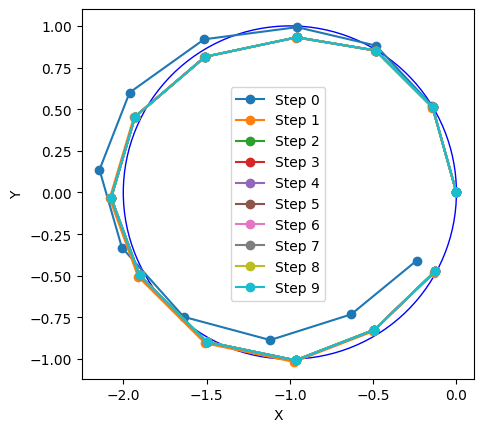

[[-1.41664126e-17 -5.55951128e-17  1.40704047e-16]
 [-1.42842831e-01  5.10642266e-01  4.86147968e-01]
 [-4.84482944e-01  8.52230403e-01  1.06244653e+00]
 [-9.58422095e-01  9.31622099e-01  1.53714660e+00]
 [-1.50794100e+00  8.15205665e-01  2.04117979e+00]
 [-1.92926075e+00  4.54784835e-01  2.62905135e+00]
 [-2.07278905e+00 -3.12016540e-02  3.20489811e+00]
 [-1.90176135e+00 -4.98165269e-01 -2.57202080e+00]
 [-1.49845639e+00 -8.96772192e-01 -2.00008183e+00]
 [-9.65912417e-01 -1.00742220e+00 -1.49338214e+00]
 [-4.91896059e-01 -8.23689937e-01 -1.01446866e+00]
 [-1.27889865e-01 -4.73350770e-01 -5.30637867e-01]]
CPU times: total: 141 ms
Wall time: 232 ms


In [121]:
%%time

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

fig, ax = plt.subplots()
circle = Circle((-1, 0), 1, color='blue', fill=False)
ax.add_patch(circle)

ax.set_xlabel('X')
ax.set_ylabel('Y')

ax.set_aspect('equal')

poses, ax = graph_optimize(poses, ax)

ax.legend()

plt.show()
print(poses.T)

In [122]:
#save_poses_kitti(poses, "data\data_kitti_optimized.txt")

# PyPose

In [123]:
import os
import torch
import argparse
import pypose as pp
from torch import nn
import torch.utils.data as Data
# from pgo_dataset_tutorial import G2OPGO
import matplotlib.pyplot as plt
import pypose.optim.solver as ppos
import pypose.optim.kernel as ppok
import pypose.optim.corrector as ppoc
import pypose.optim.strategy as ppost
from pypose.optim.scheduler import StopOnPlateau

In [124]:

"""
Ref from Pose Graph Optimization Dataset Tutorial
========================================

"""
class G2OPGO(Data.Dataset):
    def __init__(self, root, dataname, device='cpu'):
        super().__init__()

        def info2mat(info):
            mat = np.zeros((6,6))
            ix = 0
            for i in range(mat.shape[0]):
                mat[i,i:] = info[ix:ix+(6-i)]
                mat[i:,i] = info[ix:ix+(6-i)]
                ix += (6-i)
            return mat
        
        self.dtype = torch.get_default_dtype()
        filename = os.path.join(root, dataname)
        ids, nodes, edges, poses, infos = [], [], [], [], []
        with open(filename) as f:
            for line in f:
                line = line.split()
                if line[0] == 'VERTEX_SE3:QUAT':
                    ids.append(torch.tensor(int(line[1]), dtype=torch.int64))
                    nodes.append(pp.SE3(np.array(line[2:], dtype=np.float64)))
                elif line[0] == 'EDGE_SE3:QUAT':
                    edges.append(torch.tensor(np.array(line[1:3], dtype=np.int64)))
                    poses.append(pp.SE3(np.array(line[3:10], dtype=np.float64)))
                    infos.append(torch.tensor(info2mat(np.array(line[10:], dtype=np.float64))))
        
        self.ids = torch.stack(ids)
        self.nodes = torch.stack(nodes).to(self.dtype).to(device)
        self.edges = torch.stack(edges).to(device) # have to be LongTensor
        self.poses = torch.stack(poses).to(self.dtype).to(device)
        # print(self.poses.size())
        # print(self.nodes.size())
        # print(self.edges.size())
        
        self.infos = torch.stack(infos).to(self.dtype).to(device)
        assert self.ids.size(0) == self.nodes.size(0) \
               and self.edges.size(0) == self.poses.size(0) == self.infos.size(0)

    def init_value(self):
        return self.nodes.clone()

    def __getitem__(self, i):
        return self.edges[i], self.poses[i], self.infos[i]

    def __len__(self):
        return self.edges.size(0)

In [125]:
class PoseGraph(nn.Module):
    def __init__(self, nodes):
        super().__init__()
        self.nodes = nn.Parameter(nodes)
        
    def forward(self, edges, poses):

        node_gt = self.nodes[0].detach().reshape(1, 7)
        # Extracting the remaining elements of node1 and node2 for gradient tracking
        node1 = torch.cat([node_gt, self.nodes[edges[1:, 0]]], dim=0)
        node2 = torch.cat([self.nodes[edges[1:, 0]], node_gt], dim=0)

        error = poses.Inv() @ (node1.Inv() @ node2)
        return error.Log().tensor()


@torch.no_grad()
def plot_and_save(points, pngname, title='', axlim=None, save=False):
    points = points.detach().cpu().numpy()
    plt.figure(figsize=(7, 7))
    # ax = plt.axes(projection='3d')
    ax = plt.axes(projection='rectilinear')
    circle = Circle((-1, 0), 1, color='blue', fill=False)
    ax.add_patch(circle)    
    ax.plot(points[:,0], points[:,1], 'b')
    plt.title(title)
    if axlim is not None:
        ax.set_xlim(axlim[0])
        ax.set_ylim(axlim[1])
        # ax.set_zlim(axlim[2])
    if save:
        plt.savefig(pngname)
        print('Saving to', pngname)
    return ax.get_xlim(), ax.get_ylim()

In [126]:
nodes = pp.randn_SE3(12)
edges = torch.tensor([[i, (i + 1) % 12] for i in range(12)], dtype=torch.int64)
poses = pp.randn_SE3(12)

pose_graph = PoseGraph(nodes)
optimizer = torch.optim.SGD(pose_graph.parameters(), lr=0.1)

origin_nodes = nodes[0].clone()

for i in range(1):
    optimizer.zero_grad()
    error = pose_graph(edges, poses)
    loss = torch.sum(error)  # Example loss function
    loss.backward()
    optimizer.step()

print(torch.equal(pose_graph.nodes[0], origin_nodes))

True


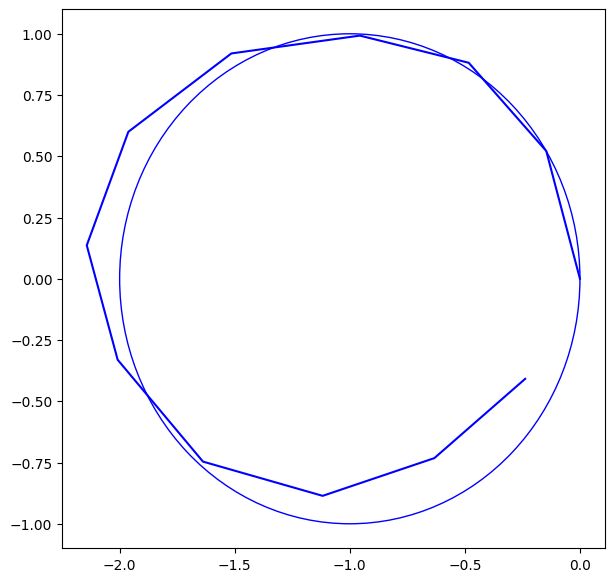

In [127]:
data = G2OPGO("D:\Courses\CS284-SLAM\hw1\data", "data_SE3.txt", device="cpu")
edges, poses, infos = data.edges, data.poses, data.infos
graph = PoseGraph(data.nodes).to("cpu")
solver = ppos.Cholesky()
strategy = ppost.TrustRegion(radius=1)
optimizer = pp.optim.LM(graph, solver=solver, strategy=strategy, min=1e-6)
scheduler = StopOnPlateau(optimizer, steps=10, patience=3, decreasing=1e-3, verbose=True)

pngname = "output/test.png"
axlim = plot_and_save(graph.nodes.translation(), pngname)

In [128]:
%%time
# for _ in range(10):
#     loss = optimizer.step(input=(edges, poses), weight=infos)
#     scheduler.step(loss)

#     name = os.path.join("output", "test" + '_' + str(scheduler.steps))
#     title = 'PyPose PGO at the %d step(s) with loss %7f'%(scheduler.steps, loss.item())
#     if scheduler.steps % 1 == 0:
#         plot_and_save(graph.nodes.translation(), name+'.png', title, axlim=axlim)
#     # torch.save(graph.state_dict(), name+'.pt')
scheduler.optimize(input=(edges, poses), weight=infos)

StopOnPlateau on step 0 Loss 2.668789e-02 --> Loss 1.711331e-02 (reduction/loss: 3.5876e-01).


StopOnPlateau on step 1 Loss 1.711331e-02 --> Loss 1.241978e-02 (reduction/loss: 2.7426e-01).
StopOnPlateau on step 2 Loss 1.241978e-02 --> Loss 9.933783e-03 (reduction/loss: 2.0016e-01).
StopOnPlateau on step 3 Loss 9.933783e-03 --> Loss 8.135770e-03 (reduction/loss: 1.8100e-01).
StopOnPlateau on step 4 Loss 8.135770e-03 --> Loss 6.534585e-03 (reduction/loss: 1.9681e-01).
StopOnPlateau on step 5 Loss 6.534585e-03 --> Loss 5.231419e-03 (reduction/loss: 1.9943e-01).
StopOnPlateau on step 6 Loss 5.231419e-03 --> Loss 4.431904e-03 (reduction/loss: 1.5283e-01).
StopOnPlateau on step 7 Loss 4.431904e-03 --> Loss 4.114298e-03 (reduction/loss: 7.1664e-02).
StopOnPlateau on step 8 Loss 4.114298e-03 --> Loss 4.049830e-03 (reduction/loss: 1.5669e-02).
StopOnPlateau: Maximum patience steps reached, Quiting..
CPU times: total: 906 ms
Wall time: 156 ms


((-2.250007438659668, 0.1071432113647461), (-1.1, 1.1))

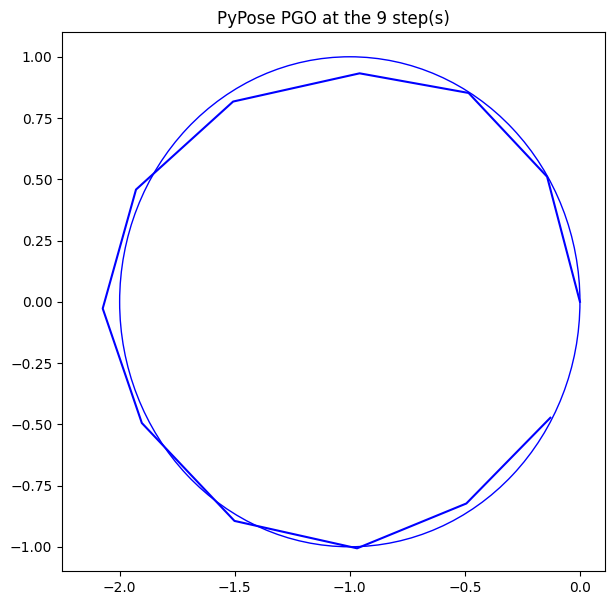

In [129]:
title = 'PyPose PGO at the %d step(s)'%(scheduler.steps)
name = os.path.join("output", "test" + '_' + str(scheduler.steps))
plot_and_save(graph.nodes.translation(), name+'.png', title, axlim=axlim)

In [130]:
import numpy as np
from scipy.spatial.transform import Rotation

def relative_pose_to_edge_se3quat(relative_poses, start_idx=0):
    nodes = ["VERTEX_SE3:QUAT 0 0.0 0.0 0.0 0.0 0.0 0.0 1.0"]
    prev_pose = np.eye(4)
    
    for i, relative_pose in enumerate(relative_poses.T):
        x, y, theta = relative_pose
        
        rotation = Rotation.from_euler('z', theta, degrees=False).as_matrix()
        translation = np.array([x, y, 0])
        transformation = np.eye(4)
        transformation[:3, :3] = rotation
        transformation[:3, 3] = translation
        
        global_pose = prev_pose @ transformation
        
        position = global_pose[:3, 3]
        rotation_quat = Rotation.from_matrix(global_pose[:3, :3]).as_quat()
        
        node_str = f"VERTEX_SE3:QUAT {i+1} {' '.join(map(str, position))} {' '.join(map(str, rotation_quat))}"
        nodes.append(node_str)
        
        prev_pose = global_pose
    
    return nodes


relative_poses = np.loadtxt("D:\Courses\CS284-SLAM\hw1\data\hw1_data.txt")
relative_poses = relative_poses[:,:-1]
nodes = relative_pose_to_edge_se3quat(relative_poses)
for node in nodes:
    print(node)


VERTEX_SE3:QUAT 0 0.0 0.0 0.0 0.0 0.0 0.0 1.0
VERTEX_SE3:QUAT 1 -0.146303 0.52145 0.0 0.0 0.0 0.2295209844116302 0.9733037129872238
VERTEX_SE3:QUAT 2 -0.4832159130176794 0.8816815125567745 0.0 0.0 0.0 0.4877421231072942 0.8729877555537586
VERTEX_SE3:QUAT 3 -0.9562474466578346 0.9925292273868188 0.0 0.0 0.0 0.6735801494385327 0.7391141875802167
VERTEX_SE3:QUAT 4 -1.5144961961598113 0.9197460709735431 0.0 0.0 0.0 0.834056315679578 0.5516793110811823
VERTEX_SE3:QUAT 5 -1.9621584633284468 0.5999558406733705 0.0 0.0 0.0 0.9576185611074723 0.28803939213665586
VERTEX_SE3:QUAT 6 -2.142864317930549 0.13654905145948348 0.0 0.0 0.0 0.999990419520363 0.00437731281592427
VERTEX_SE3:QUAT 7 -2.008573862658633 -0.3304874975897977 0.0 0.0 0.0 0.9692780906023941 -0.24596744312647773
VERTEX_SE3:QUAT 8 -1.6378854512054495 -0.7462448408470337 0.0 0.0 0.0 0.8614089339463719 -0.5079120480136055
VERTEX_SE3:QUAT 9 -1.117908561525256 -0.88596666582979 0.0 0.0 0.0 0.7097206889531399 -0.7044831748678463
VERTEX_SE

In [131]:
import numpy as np
from scipy.spatial.transform import Rotation

def relative_pose_to_edge_se3quat(relative_poses, start_idx=0):
    edges = []
    prev_pose = np.eye(4)
    
    for i, relative_pose in enumerate(relative_poses.T):
        j = (i + 1) % (relative_poses.T.shape[1])
        x, y, theta = relative_pose
        
        rotation = Rotation.from_euler('z', theta, degrees=False).as_matrix()
        translation = np.array([x, y, 0])
        transformation = np.eye(4)
        transformation[:3, :3] = rotation
        transformation[:3, 3] = translation
                
        position = transformation[:3, 3]
        rotation_quat = Rotation.from_matrix(transformation[:3, :3]).as_quat()
        
        edge_str = f"EDGE_SE3:QUAT {start_idx + i} {start_idx + i + 1} {' '.join(map(str, position))} {' '.join(map(str, rotation_quat))} 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1"
        edges.append(edge_str)
            
    return edges

relative_poses = np.loadtxt("D:\Courses\CS284-SLAM\hw1\data\hw1_data.txt")
relative_poses = relative_poses[:,:-1]
edges = relative_pose_to_edge_se3quat(relative_poses)
for edge in edges:
    print(edge)

EDGE_SE3:QUAT 0 1 -0.146303 0.52145 0.0 0.0 0.0 0.2295209844116302 0.9733037129872238 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1
EDGE_SE3:QUAT 1 2 -0.140469 0.472806 0.0 0.0 0.0 0.27435221036660284 0.9616292761074609 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1
EDGE_SE3:QUAT 2 3 -0.153574 0.460935 0.0 0.0 0.0 0.22753009977481223 0.9737710478836716 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1
EDGE_SE3:QUAT 3 4 -0.124153 0.549113 0.0 0.0 0.0 0.2448626233594505 0.9695577835701842 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1
EDGE_SE3:QUAT 4 5 -0.119121 0.537101 0.0 0.0 0.0 0.28805727389423913 0.9576131823218702 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1
EDGE_SE3:QUAT 5 6 -0.104924 0.486201 0.0 0.0 0.0 0.28384483658082216 0.9588702251850385 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1
EDGE_SE3:QUAT 6 7 -0.138374 0.465843 0.0 0.0 0.0 0.25020792004858594 0.9681921280122868 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1
EDGE_SE3:QUAT 7 8 -0.127593 0.542203 0.0 0.0 0.0 0.280429467123485 0.9598746345064225 1 0 0 0

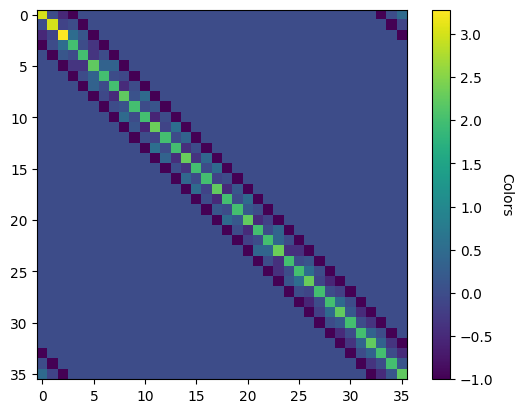

In [132]:
import numpy as np
import matplotlib.pyplot as plt

H_matrix = np.loadtxt("D:\Courses\CS284-SLAM\hw1\output\H.txt")

fig, ax = plt.subplots()
im = ax.imshow(H_matrix)

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Colors', rotation=-90, va="bottom")

plt.show()